# Mask R-CNN - Inspect Malaria Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import os
os.chdir('drive/My Drive/Mask_RCNN')

In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 163kB 7.6MB/s 
     |████████████████████████████████| 204kB 12.2MB/s 


In [4]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/Copy of __init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np

%tensorflow_version 1.x
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = "."
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = ROOT_DIR + '/logs'

# Path to Malaria trained weights
MALARIA_WEIGHTS_PATH = ROOT_DIR + '/mask_rcnn_malaria_final.h5'

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

sys.path.append(os.path.join(ROOT_DIR, "samples/malaria/"))
import malaria_config

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


## Configurations

In [6]:
config = malaria_config.MalariaConfig()
MALARIA_DIR = ROOT_DIR + '/datasets/malaria'

In [7]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [8]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [10]:
# Load validation dataset
dataset = malaria_config.CellDataset()
dataset.load_cell(MALARIA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 64
Classes: ['BG', 'uninfectedretic', 'ring', 'trophozoite', 'schizont']


## Load Model

In [11]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [12]:
# Load weights
print("Loading weights ", MALARIA_WEIGHTS_PATH)
model.load_weights(MALARIA_WEIGHTS_PATH, by_name=True)

Loading weights  ./mask_rcnn_malaria_final.h5


## Run Detection

In [13]:
image_id = 14
#image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: cell.ring_26.png (14) ./datasets/malaria/val/ring_26.png


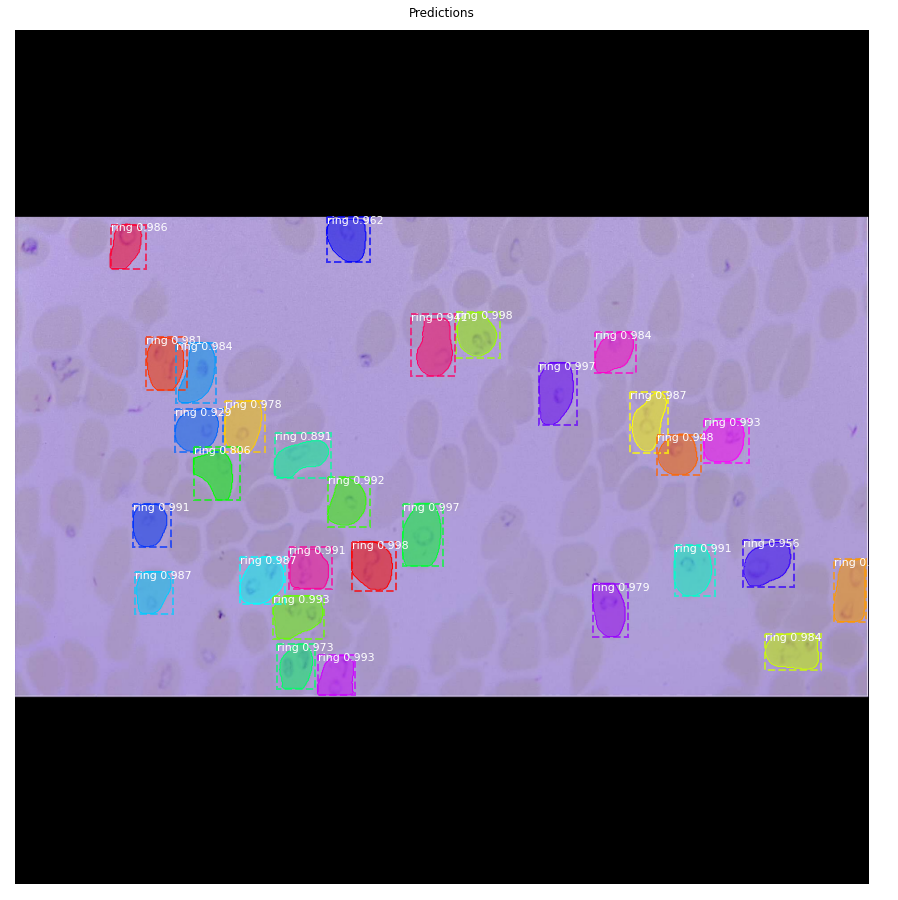

In [14]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `malaria_config.py` with the `splash` option to get better images without the black padding.

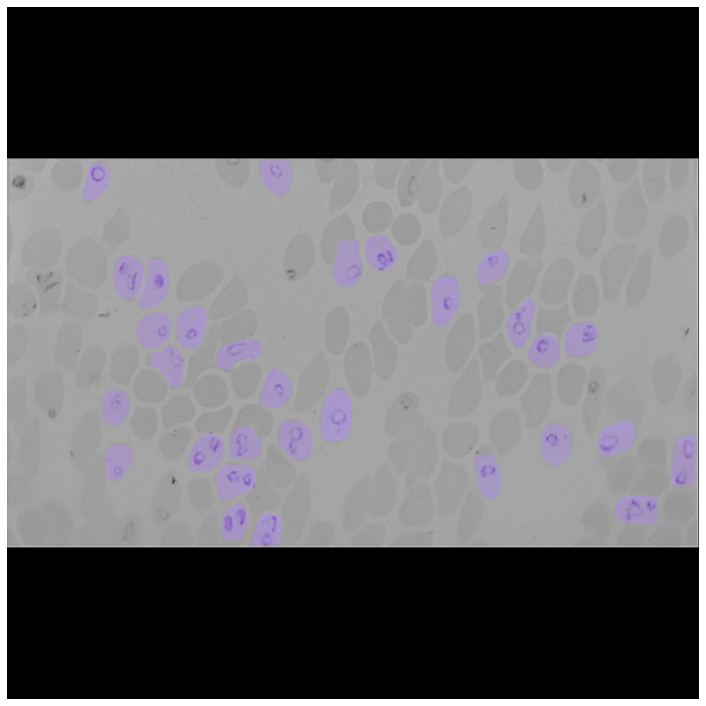

In [15]:
splash = malaria_config.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Testing with specific images
Predictions might be slightly different from reported results in publication as weights have been updated

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import watershed
from scipy.ndimage.morphology import binary_fill_holes
import imutils

def totalcellcount(filename):
  img = cv2.imread(filename)
  
  #===Increase the contrast of the image using histogram equalisation===
  #converting the color space of the image 
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray_img = cv2.cvtColor(gray_img,cv2.COLOR_GRAY2BGR)


  #LAB color space 
  #L = lightness / intensity
  #a = color component ranging from Green to Magenta
  #b = color component ranging from Blue to Yellow
  lab= cv2.cvtColor(gray_img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)

  #clahe = histogram equalisation
  #to improve contrast of the image
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)
  limg = cv2.merge((cl,a,b))
  final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
  final = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
  #cv2.imshow("final",final)

  blur = cv2.blur(final,(3,3))

  #===end===

  th, threshed = cv2.threshold(blur, 175, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

  #use binary_fill_holes to create mask for watershed
  test1 = binary_fill_holes(threshed)

  #===Morphological Opening===
  #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
  #Morphological Opening to remove small holes inside the foreground objects or black points on the object
  kernel5 = np.ones((5,5),np.uint8)
  kernel7 = np.ones((7,7),np.uint8)
  kernel2 = np.ones((2,2),np.uint8)
  kernel3 = np.ones((3,3),np.uint8)
  kernel4 = np.ones((4,4),np.uint8)

  opening = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kernel7)

  test = opening.copy()

  for i in range(9):
      test = cv2.erode(test,kernel5,iterations = 1)
      test = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel5)
      test = cv2.dilate(test, kernel2,iterations = 1)
      test = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel5)
      test = cv2.dilate(test, kernel3,iterations = 1)

  #https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
  # Marker labelling
  ret, markers = cv2.connectedComponents(test)

  #Apply watershed
  labels = watershed(final,markers,mask=opening)

  #Count total number of cells and draw contour
  cell_count = 0
  for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
      if label == 0:
          continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
      mask = np.zeros(blur.shape, dtype="uint8")
      mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
      cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = imutils.grab_contours(cnts)
      #c = max(cnts, key=cv2.contourArea)

      for cnt in cnts:
          if cv2.contourArea(cnt) > 300:
              cv2.drawContours(img, [cnt], -1, (0,255,0), 3)
              cell_count += 1
      
  return cell_count

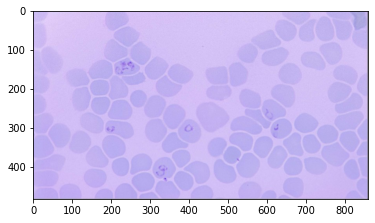

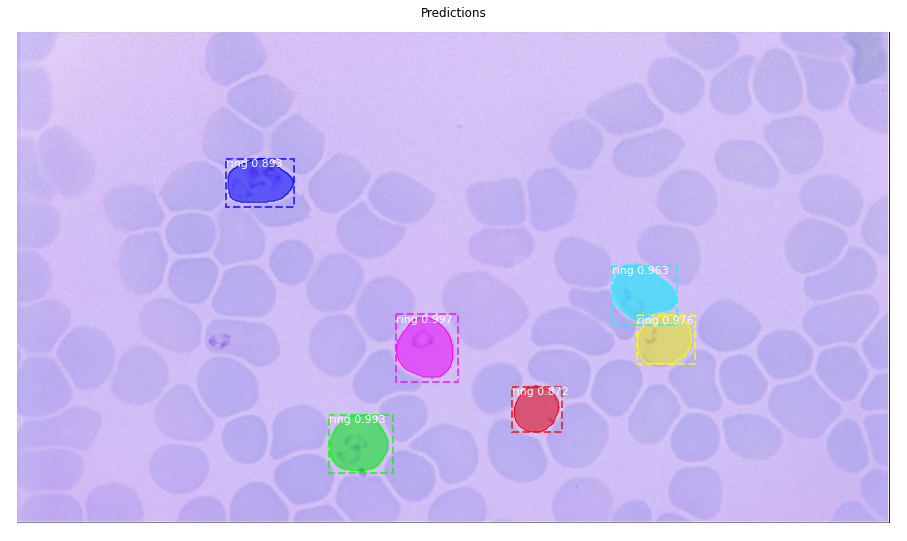

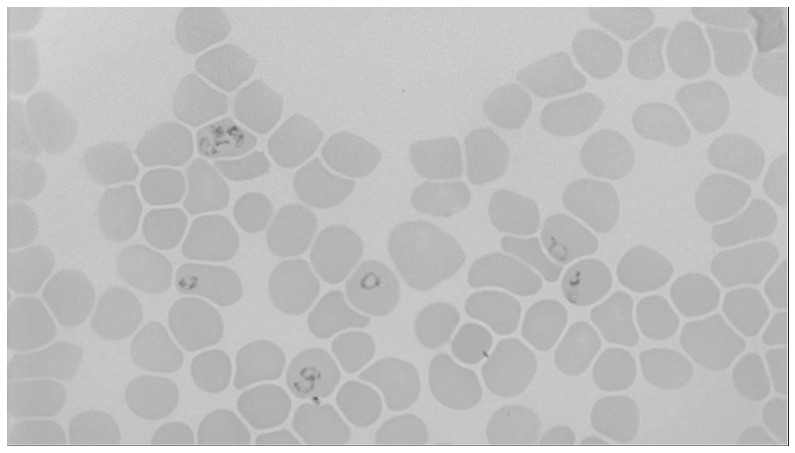

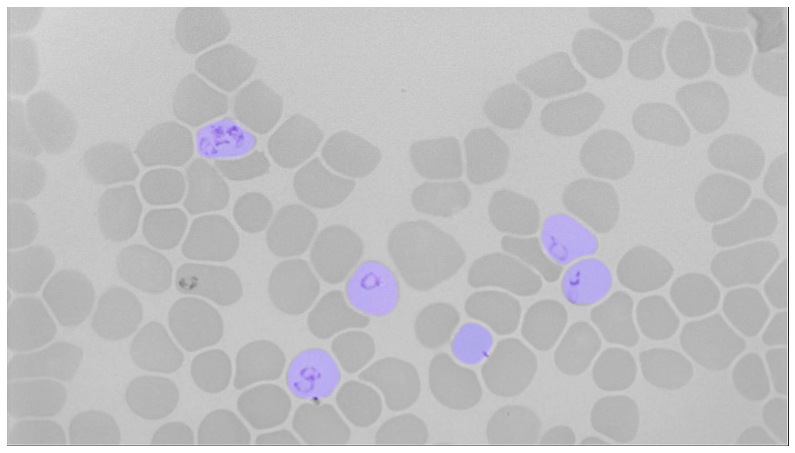

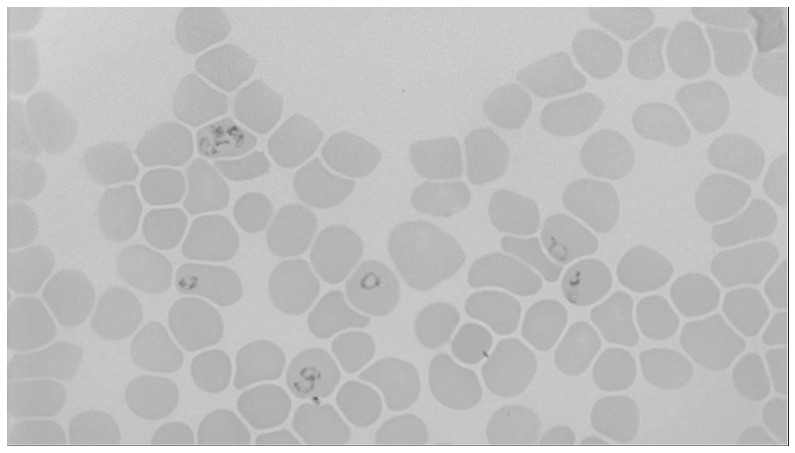

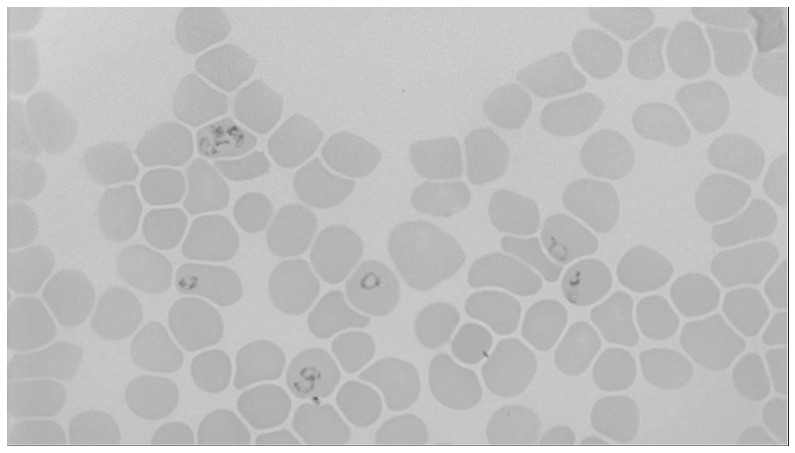

The number of normocytes is: 100
The number of uninfected reticulocytes is: 0
The number of rings is: 6
The number of trophozoites is: 0
The number of schizonts is: 0


In [17]:
img_path = "./datasets/malaria/test/image_1.jpg"

img_test = plt.imread(img_path)
plt.imshow(img_test)

# Run object detection
results = model.detect([img_test], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(img_test, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

mask_uninfectedretic = []
mask_ring = []
mask_trophozoite = []
mask_schizont = []

for i in range(len(r['class_ids'])):
  el = r['class_ids'][i]
  col = np.transpose(r['masks'][:,:,i])
  
  if el == 1:
    mask_uninfectedretic.append(col)
  if el == 2:
    mask_ring.append(col)
  if el == 3:
    mask_trophozoite.append(col)
  if el == 4:
    mask_schizont.append(col)
    
mask_uninfectedretic = np.transpose(np.array(mask_uninfectedretic))
mask_ring = np.transpose(np.array(mask_ring))
mask_trophozoite = np.transpose(np.array(mask_trophozoite))
mask_schizont = np.transpose(np.array(mask_schizont))
    
splash = malaria_config.color_splash(img_test, np.array(mask_uninfectedretic))
display_images([splash], cols=1)

splash = malaria_config.color_splash(img_test, np.array(mask_ring))
display_images([splash], cols=1)

splash = malaria_config.color_splash(img_test, np.array(mask_trophozoite))
display_images([splash], cols=1)

splash = malaria_config.color_splash(img_test, np.array(mask_schizont))
display_images([splash], cols=1)

# Get predictions of mask head
mrcnn = model.run_graph([img_test], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

ls = list(np.array(dataset.class_names)[det_class_ids])

print("The number of normocytes is: {}".format(totalcellcount(img_path)-det_count))
print("The number of uninfected reticulocytes is: {}".format(ls.count("uninfectedretic")))
print("The number of rings is: {}".format(ls.count("ring")))
print("The number of trophozoites is: {}".format(ls.count("trophozoite")))
print("The number of schizonts is: {}".format(ls.count("schizont")))


# Predict for all test images

In [18]:
from os import listdir
from os.path import isfile, join
mypath = "./datasets/malaria/test"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = sorted(onlyfiles)

In [19]:
def predict():
  start_time = time.time()
  normocyte_total = 0
  uninfectedretic_total = 0
  ring_total = 0
  trophozoite_total = 0
  schizont_total = 0
  error_count = 0
  analysed_count = 0
  error_ls = []

  for file in onlyfiles:
    img = plt.imread(mypath + "/" + file)
      # Get predictions of mask head
    mrcnn = model.run_graph([img], [
        ("detections", model.keras_model.get_layer("mrcnn_detection").output),
        ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ])
    # Get detection class IDs. Trim zero padding.
    det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
    det_count = np.where(det_class_ids == 0)[0][0]
    det_class_ids = det_class_ids[:det_count]

    cellcount = totalcellcount(mypath + "/" + file)
    
    if cellcount > det_count:
      ls = list(np.array(dataset.class_names)[det_class_ids])
      
      num_normocyte = cellcount - det_count
      print('\033[1m' + file + '\033[0m')
      print("Total: {}".format(cellcount))
      print("Normocytes: {}".format(num_normocyte))
      print("Uninfected Reticulocytes: {}".format(ls.count("uninfectedretic")))
      print("Rings: {}".format(ls.count("ring")))
      print("Trophozoites: {}".format(ls.count("trophozoite")))
      print("Schizonts: {}\n".format(ls.count("schizont")))
      
      normocyte_total += num_normocyte
      uninfectedretic_total += ls.count("uninfectedretic")
      ring_total += ls.count("ring")
      trophozoite_total += ls.count("trophozoite")
      schizont_total += ls.count("schizont")
      analysed_count += 1
      
    else:
      error_count += 1
      error_ls.append(file)
      
  infected = ring_total + trophozoite_total + schizont_total
  uninfected = normocyte_total + uninfectedretic_total
  parasitemia = round(infected/(uninfected+infected),3)
  
  print('\033[1m' + 'Sample Report' + '\033[0m')
  print("Parasitemia: {}%".format(100*parasitemia))
  print("Normocytes: {}".format(normocyte_total))
  print("Uninfected Reticulocytes: {}".format(uninfectedretic_total))
  print("Rings: {}".format(ring_total))
  print("Trophozoites: {}".format(trophozoite_total))
  print("Schizonts: {}\n".format(schizont_total))
  
  totalcount = analysed_count + error_count
  elapsed_time = time.time() - start_time
  print("Images processsed: {}".format(totalcount))
  if elapsed_time < 60:
    print("Time taken: {}s".format(round(elapsed_time,3)))
  else:
    minutes = int(elapsed_time//60)
    seconds = round(elapsed_time%60,3)
    print("Time taken: {}min {}s".format(minutes, seconds))
  print("Average time taken per image: {}s\n".format(round(elapsed_time/totalcount,3)))
  
  error_str = ', '.join(error_ls)
  print("Error in processing these images: {}".format(error_str))
  
def generate_masks(filename):
  
  img_test = plt.imread(mypath + "/" + filename) 

  # Run object detection
  results = model.detect([img_test], verbose=1)

  # Display results
  r = results[0]

  mask_uninfectedretic = []
  mask_ring = []
  mask_trophozoite = []
  mask_schizont = []

  for i in range(len(r['class_ids'])):
    el = r['class_ids'][i]
    col = np.transpose(r['masks'][:,:,i])

    if el == 1:
      mask_uninfectedretic.append(col)
    if el == 2:
      mask_ring.append(col)
    if el == 3:
      mask_trophozoite.append(col)
    if el == 4:
      mask_schizont.append(col)

  mask_uninfectedretic = np.transpose(np.array(mask_uninfectedretic))
  mask_ring = np.transpose(np.array(mask_ring))
  mask_trophozoite = np.transpose(np.array(mask_trophozoite))
  mask_schizont = np.transpose(np.array(mask_schizont))

  splash = malaria_derong.color_splash(img_test, np.array(mask_uninfectedretic))
  print('     \033[1m' + 'Uninfected Reticulocyte mask' + '\033[0m')
  display_images([splash],cols=1)

  splash = malaria_derong.color_splash(img_test, np.array(mask_ring))
  print('     \033[1m' + 'Ring mask' + '\033[0m')
  display_images([splash], cols=1)

  splash = malaria_derong.color_splash(img_test, np.array(mask_trophozoite))
  print('     \033[1m' + 'Trophozoite mask' + '\033[0m')
  display_images([splash], cols=1)

  splash = malaria_derong.color_splash(img_test, np.array(mask_schizont))
  print('     \033[1m' + 'Schizont mask' + '\033[0m')
  display_images([splash], cols=1)

In [20]:
predict()

image_1.jpg
Total: 106
Normocytes: 100
Uninfected Reticulocytes: 0
Rings: 6
Trophozoites: 0
Schizonts: 0

image_10.jpg
Total: 96
Normocytes: 92
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 0
Schizonts: 4

image_11.jpg
Total: 105
Normocytes: 98
Uninfected Reticulocytes: 0
Rings: 3
Trophozoites: 2
Schizonts: 2

image_12.jpg
Total: 101
Normocytes: 97
Uninfected Reticulocytes: 0
Rings: 2
Trophozoites: 1
Schizonts: 1

image_13.jpg
Total: 93
Normocytes: 91
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 0
Schizonts: 2

image_14.jpg
Total: 95
Normocytes: 87
Uninfected Reticulocytes: 0
Rings: 2
Trophozoites: 4
Schizonts: 2

image_15.jpg
Total: 82
Normocytes: 72
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 2
Schizonts: 8

image_16.jpg
Total: 114
Normocytes: 110
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 4
Schizonts: 0

image_17.jpg
Total: 134
Normocytes: 129
Uninfected Reticulocytes: 0
Rings: 2
Trophozoites: 3
Schizonts: 0

image_18.jpg
Total: 80
Normocytes: 75
Uninfected

# Train Model

In [ ]:
import os
os.chdir('/content/drive/My Drive/Mask_RCNN/samples/malaria')

In [ ]:
!python3 malaria_config.py train --dataset=../../datasets/malaria --weights=../../mask_rcnn_0050.h5 --logs=../../logs

Using TensorFlow backend.
Weights:  ../../mask_rcnn_0050.h5
Dataset:  ../../datasets/malaria
Logs:  ../../logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_lo